# Human Or Horse Classfication

## Contents

[1. Loading the Data](#1)

[2. Preprocessing](#2)

[3. Model](#3)

[4. Prediction on Test Data](#4)

### 1. Loading The Data

In [4]:
import tensorflow as tf
from tensorflow import keras
import tensorflow_datasets as tfds
import os
import cv2
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
 #Define paths to the uploaded folders
horses_dir = "/content/drive/MyDrive/CV 2 /train/horses"
humans_dir = "/content/drive/MyDrive/CV 2 /train/humans"

test_data_dir = "/content/drive/MyDrive/CV 2 /test"

In [6]:
def load_images(folder_path, label):
    images = []
    labels = []

    for filename in os.listdir(folder_path):
        img_path = os.path.join(folder_path, filename)
        if img_path.lower().endswith(('.jpg', '.jpeg', '.png')):
            image = cv2.imread(img_path)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            image = cv2.resize(image, (300, 300))
            images.append(image)
            labels.append(label)
    return images, labels

In [7]:
def load_test_images(folder_path):
    test_images = []
    image_names = []  # List to store image names

    for filename in os.listdir(folder_path):
        img_path = os.path.join(folder_path, filename)
        if img_path.lower().endswith(('.jpg', '.jpeg', '.png')):
            image = cv2.imread(img_path)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            image = cv2.resize(image, (300, 300))
            test_images.append(image)
            image_names.append(filename)  # Append image filename to the list

    return test_images, image_names


In [8]:
horses_images, horses_labels = load_images(horses_dir, label=0)
humans_images, humans_labels = load_images(humans_dir, label=1)
test_images,imageNames=load_test_images(test_data_dir)

X = np.array(horses_images + humans_images)
y = np.array(horses_labels + humans_labels)
X_test = np.array(test_images)
imageNames=np.array(imageNames)

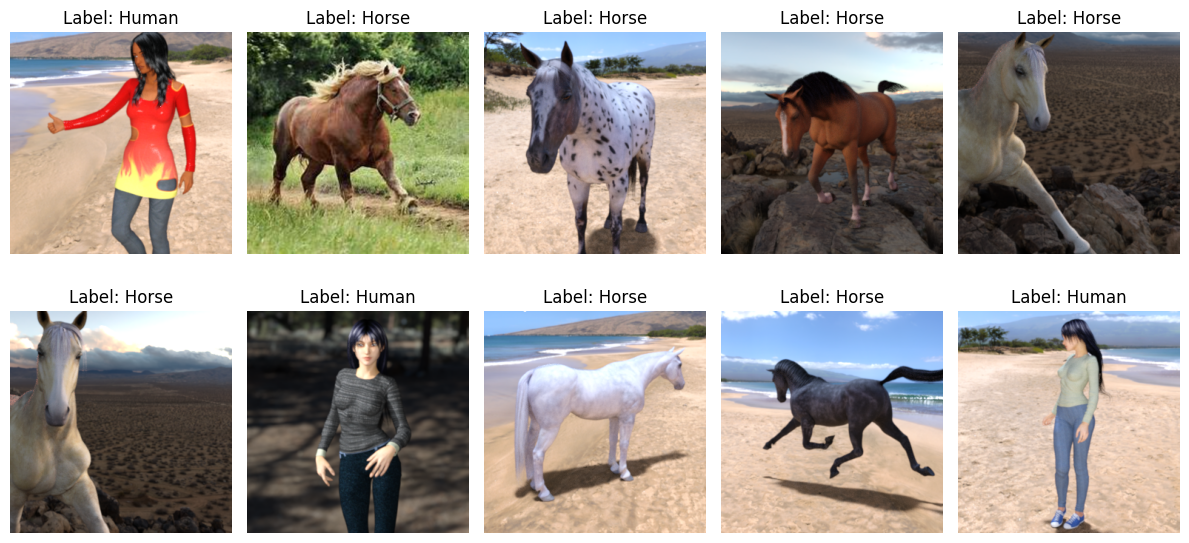

In [41]:
import matplotlib.pyplot as plt
import random

fig, axs = plt.subplots(2, 5, figsize=(12, 6))

for i in range(5):
    for j in range(2):
        random_index = random.randint(0, 1199)
        image = X[random_index]
        label = y[random_index]

        class_names = ['Horse', 'Human']

        axs[j, i].imshow(image)
        axs[j, i].set_title(f"Label: {class_names[label]}")
        axs[j, i].axis('off')

plt.tight_layout()
plt.show()


### 2. Preprocessing

In [9]:
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Assuming you have arrays x (image data) and y (labels)

# Shuffle and split the data into training and validation sets
x_train, x_val, y_train, y_val = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=42)

# Define image preprocessing settings for training data (with augmentation)
train_datagen = ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True
)

# Define image preprocessing settings for validation data (without augmentation)
val_datagen = ImageDataGenerator(
    rescale=1.0/255
)

# Create data generators
train_generator = train_datagen.flow(
    x_train, y_train,
    batch_size=32,
    shuffle=True,  # Shuffle the training data
)

val_generator = val_datagen.flow(
    x_val, y_val,
    batch_size=32,
    shuffle=False,  # Do not shuffle the validation data
)


In [43]:
x_train.shape

(960, 300, 300, 3)

### 3. Model

#### Trail 1

In [44]:
import tensorflow as tf

cnn_model = tf.keras.models.Sequential([
    # Note the input shape is the desired size of the image 300x300 with 3 bytes color
    # This is the first convolution
    tf.keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=(300, 300, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    # The second convolution
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # The third convolution
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # The fourth convolution
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # The fifth convolution
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # Flatten the results to feed into a DNN
    tf.keras.layers.Flatten(),
    # 512 neuron hidden layer
    tf.keras.layers.Dense(512, activation='relu'),
    # Only 1 output neuron. It will contain a value from 0-1 where 0 for 1 class ('horses') and 1 for the other ('humans')
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [45]:
cnn_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_13 (Conv2D)          (None, 298, 298, 16)      448       
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 149, 149, 16)     0         
 g2D)                                                            
                                                                 
 conv2d_14 (Conv2D)          (None, 147, 147, 32)      4640      
                                                                 
 max_pooling2d_14 (MaxPoolin  (None, 73, 73, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_15 (Conv2D)          (None, 71, 71, 64)        18496     
                                                                 
 max_pooling2d_15 (MaxPoolin  (None, 35, 35, 64)      

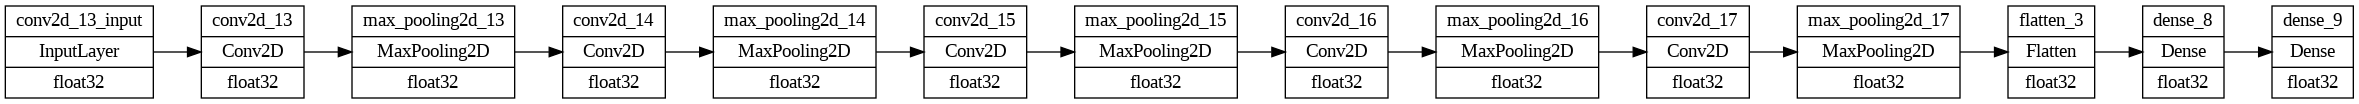

In [46]:
tf.keras.utils.plot_model(cnn_model, rankdir='LR',show_dtype=True)

In [47]:
from tensorflow.keras.optimizers import RMSprop

cnn_model.compile(loss='binary_crossentropy',
              optimizer=RMSprop(learning_rate=0.001),
              metrics=['accuracy'])

In [48]:
history = cnn_model.fit(
    train_generator,
    steps_per_epoch=len(x_train) // 32,  # Number of steps per epoch
    epochs=15,  # Number of epochs
    validation_data=val_generator,
    validation_steps=len(x_val) // 32  # Number of validation steps
)

Epoch 1/15
30/30 [==============================] - 27s 767ms/step - loss: 0.6944 - accuracy: 0.5542 - val_loss: 0.6846 - val_accuracy: 0.5000
Epoch 2/15
30/30 [==============================] - 23s 786ms/step - loss: 0.6780 - accuracy: 0.6583 - val_loss: 0.4763 - val_accuracy: 0.7857
Epoch 3/15
30/30 [==============================] - 25s 845ms/step - loss: 0.5663 - accuracy: 0.7167 - val_loss: 0.4868 - val_accuracy: 0.7679
Epoch 4/15
30/30 [==============================] - 22s 719ms/step - loss: 0.5453 - accuracy: 0.7490 - val_loss: 0.3407 - val_accuracy: 0.8929
Epoch 5/15
30/30 [==============================] - 23s 764ms/step - loss: 0.4661 - accuracy: 0.7823 - val_loss: 0.4431 - val_accuracy: 0.8571
Epoch 6/15
30/30 [==============================] - 23s 776ms/step - loss: 0.3898 - accuracy: 0.8135 - val_loss: 0.2263 - val_accuracy: 0.8973
Epoch 7/15
30/30 [==============================] - 21s 704ms/step - loss: 0.3444 - accuracy: 0.8385 - val_loss: 0.2259 - val_accuracy: 0.9152

#### Trail 2

In [10]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam

# Define your model architecture
model = tf.keras.models.Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(300, 300, 3)),
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Conv2D(256, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(loss='binary_crossentropy',
                  optimizer=Adam(learning_rate=0.001),
                  metrics=['accuracy'])

# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=len(x_train) // 32,
    epochs=20,
    validation_data=val_generator,
    validation_steps=len(x_val) // 32
)


Epoch 1/20
30/30 [==============================] - 37s 699ms/step - loss: 0.6729 - accuracy: 0.5490 - val_loss: 0.4344 - val_accuracy: 0.8839
Epoch 2/20
30/30 [==============================] - 22s 739ms/step - loss: 0.6063 - accuracy: 0.6760 - val_loss: 0.3970 - val_accuracy: 0.8795
Epoch 3/20
30/30 [==============================] - 22s 732ms/step - loss: 0.4826 - accuracy: 0.7844 - val_loss: 0.2685 - val_accuracy: 0.8929
Epoch 4/20
30/30 [==============================] - 22s 731ms/step - loss: 0.4213 - accuracy: 0.8083 - val_loss: 0.2706 - val_accuracy: 0.9330
Epoch 5/20
30/30 [==============================] - 20s 674ms/step - loss: 0.3576 - accuracy: 0.8562 - val_loss: 0.2613 - val_accuracy: 0.8973
Epoch 6/20
30/30 [==============================] - 22s 727ms/step - loss: 0.3228 - accuracy: 0.8708 - val_loss: 0.1563 - val_accuracy: 0.9420
Epoch 7/20
30/30 [==============================] - 20s 680ms/step - loss: 0.2879 - accuracy: 0.8938 - val_loss: 0.1112 - val_accuracy: 0.9598

In [12]:
train_results = model.evaluate(train_generator)
train_loss = train_results[0]
train_accuracy = train_results[1]

# Evaluate the model on validation data
validation_results = model.evaluate(val_generator)
validation_loss = validation_results[0]
validation_accuracy = validation_results[1]

print(f"Train Loss: {train_loss:.4f}")
print(f"Train Accuracy: {train_accuracy:.4f}")
print(f"Validation Loss: {validation_loss:.4f}")
print(f"Validation Accuracy: {validation_accuracy:.4f}")

8/8 [==============================] - 1s 164ms/step - loss: 0.0830 - accuracy: 0.9667
Train Loss: 0.0916
Train Accuracy: 0.9667
Validation Loss: 0.0830
Validation Accuracy: 0.9667


##### Trial 3

In [21]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# Define your model architecture
cnn3_model = tf.keras.models.Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(300, 300, 3)),
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Conv2D(256, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

# Compile the model
cnn3_model.compile(loss='binary_crossentropy',
                  optimizer=Adam(learning_rate=0.001),
                  metrics=['accuracy'])

# Define the EarlyStopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model with EarlyStopping
history = cnn3_model.fit(
    train_generator,
    steps_per_epoch=len(x_train) // 32,
    epochs=20,
    validation_data=val_generator,
    validation_steps=len(x_val) // 32,
    callbacks=[early_stopping]  # Include the EarlyStopping callback
)


Epoch 1/20
30/30 [==============================] - 23s 667ms/step - loss: 0.7205 - accuracy: 0.5135 - val_loss: 0.6775 - val_accuracy: 0.5938
Epoch 2/20
30/30 [==============================] - 21s 681ms/step - loss: 0.6875 - accuracy: 0.5542 - val_loss: 0.8040 - val_accuracy: 0.4911
Epoch 3/20
30/30 [==============================] - 20s 680ms/step - loss: 0.6515 - accuracy: 0.6375 - val_loss: 0.5436 - val_accuracy: 0.8214
Epoch 4/20
30/30 [==============================] - 23s 766ms/step - loss: 0.5960 - accuracy: 0.7021 - val_loss: 0.4377 - val_accuracy: 0.8304
Epoch 5/20
30/30 [==============================] - 21s 689ms/step - loss: 0.5269 - accuracy: 0.7667 - val_loss: 0.4157 - val_accuracy: 0.8080
Epoch 6/20
30/30 [==============================] - 22s 727ms/step - loss: 0.4287 - accuracy: 0.8010 - val_loss: 0.2980 - val_accuracy: 0.8929
Epoch 7/20
30/30 [==============================] - 20s 672ms/step - loss: 0.4201 - accuracy: 0.8375 - val_loss: 0.3044 - val_accuracy: 0.8929

In [22]:
train_results = cnn3_model.evaluate(train_generator)
train_loss = train_results[0]
train_accuracy = train_results[1]

# Evaluate the model on validation data
validation_results = cnn3_model.evaluate(val_generator)
validation_loss = validation_results[0]
validation_accuracy = validation_results[1]

print(f"Train Loss: {train_loss:.4f}")
print(f"Train Accuracy: {train_accuracy:.4f}")
print(f"Validation Loss: {validation_loss:.4f}")
print(f"Validation Accuracy: {validation_accuracy:.4f}")

8/8 [==============================] - 1s 78ms/step - loss: 0.1209 - accuracy: 0.9583
Train Loss: 0.0929
Train Accuracy: 0.9688
Validation Loss: 0.1209
Validation Accuracy: 0.9583


### 4. Prediction on Test Data

In [50]:
X_test.shape

(300, 300, 300, 3)

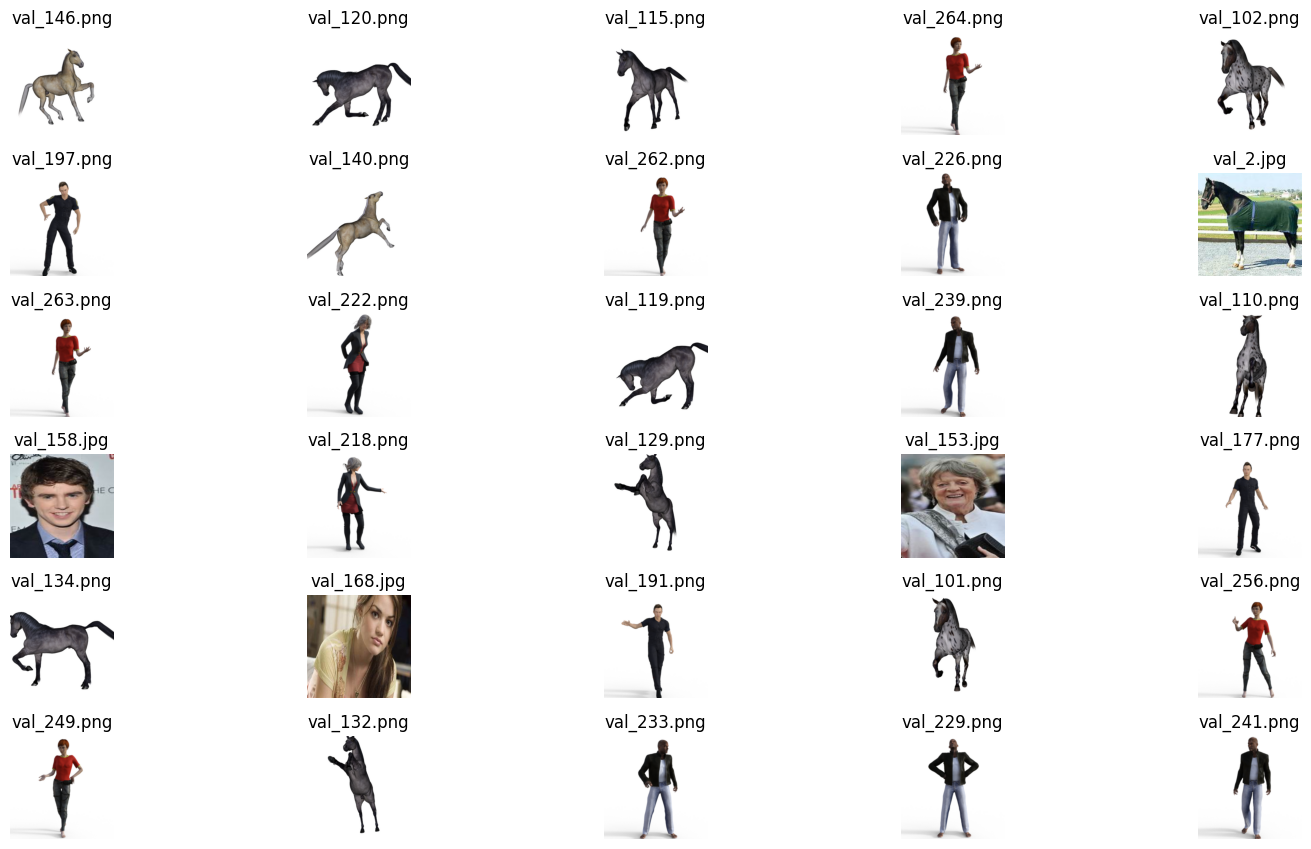

In [71]:
def plot_images(images, names, num_images=30):
    num_rows = (num_images // 5) + 1
    plt.figure(figsize=(15, 10))
    for i in range(num_images):
        plt.subplot(num_rows, 5, i + 1)
        plt.imshow(images[i])
        plt.title(names[i])
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# Plot the first 30 images
plot_images(X_test, imageNames, num_images=30)

In [23]:
predictions = cnn3_model.predict(X_test)

# Create a DataFrame to store results
results_df = pd.DataFrame({
    'ImageName': imageNames,  # List of image names
    'PredictedProbability': predictions.flatten()  # Flatten predictions to 1D array
})

# Add a column for the predicted class based on a threshold (e.g., 0.5)
results_df['PredictedClass'] = results_df['PredictedProbability'].apply(lambda x: 'human' if x >= 0.5 else 'horse')

10/10 [==============================] - 0s 27ms/step


In [24]:
results_df.drop(['PredictedProbability'],axis=1,inplace=True)

In [25]:
results_df.head(30)

,ImageName,PredictedClass
0,val_146.png,horse
1,val_120.png,horse
2,val_115.png,horse
3,val_264.png,human
4,val_102.png,horse
5,val_197.png,human
6,val_140.png,human
7,val_262.png,human
8,val_226.png,human
9,val_2.jpg,human


In [26]:
submission_df = pd.read_csv("/content/Submission_file.csv")

In [27]:
import pandas as pd

# Merge the two DataFrames based on the 'ID' column
merged_df = pd.merge(submission_df, results_df, left_on='ID', right_on='ImageName', how='left')

# Replace 'null' values with the corresponding predictions
merged_df['prediction'] = merged_df['prediction'].fillna(merged_df['PredictedClass'])

# Drop unnecessary columns
merged_df.drop(['ImageName', 'PredictedClass'], axis=1, inplace=True)

In [28]:
merged_df.head(30)

,ID,prediction
0,val_1.jpg,horse
1,val_230.png,human
2,val_28.png,horse
3,val_201.png,human
4,val_239.png,human
5,val_240.png,human
6,val_208.png,human
7,val_58.png,human
8,val_10.jpg,human
9,val_184.png,human


In [29]:
# Save the merged DataFrame to a CSV file
merged_df.to_csv('Final3_predictions.csv', index=False)